In [11]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import cmocean
def plot_metric(exp=None, metric='R2',vmin=0,vmax=1):
    exp[metric].drop_vars(['zl','factor']).plot(x='factor', y='zl',cmap=cmocean.cm.balance, vmin=vmin, vmax=vmax, cbar_kwargs={'label':''})
    plt.yticks(np.arange(10),[5, 55, 110, 180,330, 730,1500,2500,3500,4500]);
    plt.ylabel('Depth, m')
    plt.xticks(np.arange(4),[4,9,12,15]);
    if metric == 'R2':
        title_str = '$R^2$'
    elif metric == 'corr':
        title_str = 'Correlation'
    elif metric == 'opt_scaling':
        title_str = 'Optimal scaling'
    
    mean_val = float(exp[metric].mean())
    std_val = float(exp[metric].std())
    plt.title(metric+'\n [mean/std]=[%.3f,%.3f]' % (mean_val,std_val))
    
    plt.xlabel('Coarsegraining factor')
    plt.gca().invert_yaxis()

In [3]:
def read_skill(exp='EXP0', factors=[4,9,12,15]):
    ds = []
    for factor in factors:
        dataset = xr.open_dataset(f'/scratch/pp2681/mom6/CM26_ML_models/ocean3d/subfilter/{exp}/skill-test/factor-{factor}.nc', chunks={'zl':1})
        ds.append(dataset)
    ds = xr.concat(ds, dim='factor')
    ds['factor'] = factors
    return ds

In [17]:
default = read_skill('FGR3/EXP1')
repeat = read_skill('FGR3/EXP2')

In [5]:
more_neurons = read_skill('FGR3/EXP-32-32/repeat')

In [6]:
smaller_stencil = read_skill('FGR3/EXP-32-32/1x1')

In [7]:
bigger_stencil = read_skill('FGR3/EXP-32-32/5x5')

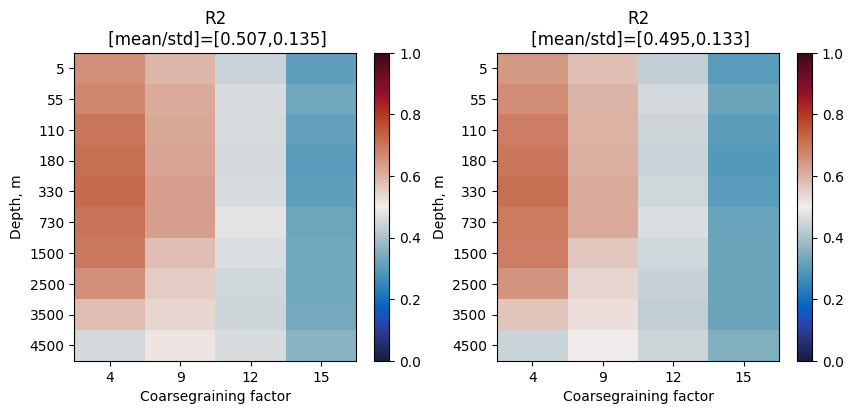

In [19]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_metric(default, 'R2')
plt.subplot(1,2,2)
plot_metric(repeat, 'R2')

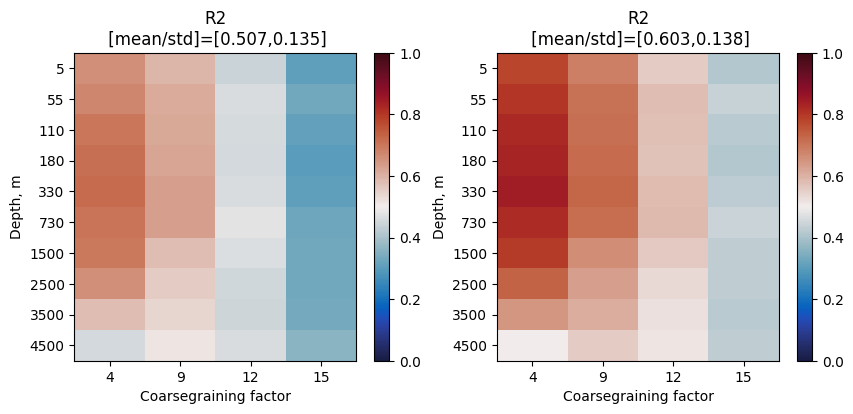

In [21]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plot_metric(default, 'R2')
plt.subplot(1,2,2)
plot_metric(more_neurons, 'R2')

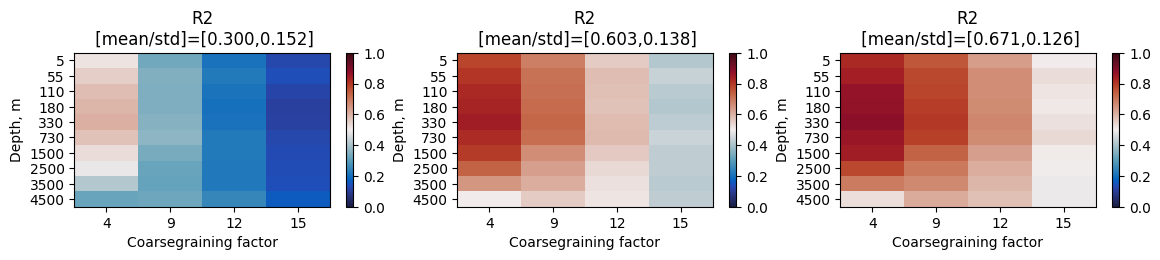

In [27]:
plt.figure(figsize=(14,2))
plt.subplot(1,3,1)
plot_metric(smaller_stencil, 'R2')
plt.subplot(1,3,2)
plot_metric(more_neurons, 'R2')
plt.subplot(1,3,3)
plot_metric(bigger_stencil, 'R2')

In [35]:
def read_skill(exp='EXP0', factors=[4,9,12,15], base_path='/scratch/pp2681/mom6/CM26_ML_models/ocean3d/'):
    ds = {}
    for factor in factors:
        data = xr.open_dataset(f'{base_path}/{exp}/skill-test/factor-{factor}.nc', chunks={'zl':1})
        data['zl'] = -data['zl']
        ds[factor] = data
        
    return ds

In [28]:
def backscatter_ratio(transfer, freq_str):
    transfer_noncompensated = transfer / transfer[freq_str]
    transfer_plus = np.maximum(transfer_noncompensated,0.0)
    transfer_minus =  np.minimum(transfer_noncompensated,0.0)
    return -transfer_plus.sum(freq_str) / transfer_minus.sum(freq_str)

In [31]:
def plot_transfer(transfer, freq_str='freq_r_NA', zl=0, color='tab:blue'):
    mean = transfer.mean('time').isel(zl=zl)
    std = transfer.std('time').isel(zl=zl)
    
    mean.plot(xscale='log',color=color,lw=2)
    plt.fill_between(mean[freq_str],mean-std,mean+std,alpha=0.05,color=color, linewidth=0)
    return backscatter_ratio(mean,freq_str)

In [32]:
def plot_transfer_4_regions(exps=[],zl=5,factor=4,labels=[]):
    plt.figure(figsize=(10,8))
    plt.rcParams['font.size']=12

    colors= ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:pink', 'tab:cyan', 'tab:olive', 'tab:brown', 'gray']
    
    plt.subplot(2,2,1)
    ratio = plot_transfer(exps[0][factor].transfer_NA,'freq_r_NA',color='k',zl=zl)
    for exp, color in zip(exps, colors):
        plot_transfer(exp[factor].transfer_ZB_NA,'freq_r_NA',zl=zl,color=color)
    plt.ylabel('Compensated energy transfer m$^2$/s$^3$')
    plt.title('North Atlantic')
    plt.axhline(y=0,color='gray')
    plt.xlabel('Wavenumber, m$^{-1}$')
    plt.axvline(x=1/(22.6e+3), color='tab:gray', ls='--')
    plt.xlim([1e-6,2e-4])
    plt.text(1e-5, 0, 'Backscat ratio: %.1f' % float(ratio))

    plt.subplot(2,2,2)
    ratio=plot_transfer(exps[0][factor].transfer_Pacific,'freq_r_Pacific',color='k',zl=zl)
    for exp, color in zip(exps,colors):
        plot_transfer(exp[factor].transfer_ZB_Pacific,'freq_r_Pacific',zl=zl,color=color)
    plt.ylabel('Compensated energy transfer m$^2$/s$^3$')
    plt.title('Pacific')
    plt.axhline(y=0,color='gray')
    plt.xlabel('Wavenumber, m$^{-1}$')
    plt.axvline(x=1/(28.5e+3), color='tab:gray', ls='--')
    plt.xlim([1e-6,2e-4])
    plt.text(1e-5, 0, 'Backscat ratio: %.1f' % float(ratio))
    
    plt.subplot(2,2,3)
    ratio=plot_transfer(exps[0][factor].transfer_ACC,'freq_r_ACC',color='k',zl=zl)
    for exp,color in zip(exps,colors):
        plot_transfer(exp[factor].transfer_ZB_ACC,'freq_r_ACC',zl=zl,color=color)
    plt.ylabel('Compensated energy transfer m$^2$/s$^3$')
    plt.title('ACC')
    plt.axhline(y=0,color='gray')
    plt.xlabel('Wavenumber, m$^{-1}$')
    plt.axvline(x=1/(10.5e+3), color='tab:gray',ls='--')
    plt.xlim([1e-6,2e-4])
    plt.text(1e-5, 0, 'Backscat ratio: %.1f' % float(ratio))
        
    plt.subplot(2,2,4)
    ratio=plot_transfer(exps[0][factor].transfer_Equator,'freq_r_Equator',color='k',zl=zl)
    for exp,color in zip(exps,colors):
        plot_transfer(exp[factor].transfer_ZB_Equator,'freq_r_Equator',zl=zl,color=color)
    plt.ylabel('Compensated energy transfer m$^2$/s$^3$')
    plt.title('Equator')
    plt.axhline(y=0,color='gray')
    plt.xlabel('Wavenumber, m$^{-1}$')
    plt.tight_layout()
    plt.axvline(x=1/(89.9e+3), color='tab:gray',ls='--')
    plt.xlim([1e-6,2e-4])
    plt.text(1e-5, 0, 'Backscat ratio: %.1f' % float(ratio))
    
    plt.plot(np.nan,np.nan,color='k',label='SFS')
    for label, color in zip(labels,colors):
        plt.plot(np.nan,np.nan,color=color,label=label)
    plt.plot(np.nan,np.nan,color='gray',ls='--',label='$1/R_d$')
    plt.legend(bbox_to_anchor=(1,1))
    
    plt.suptitle(f'Coarsegraining factor: {factor}, Depth: %.0f m' % (float(-exp[factor].zl[zl])), y=1.03)

In [39]:
default = read_skill('subfilter/FGR3/EXP1')
repeat = read_skill('subfilter/FGR3/EXP2')

In [42]:
more_neurons = read_skill('subfilter/FGR3/EXP-32-32/repeat')

In [43]:
smaller_stencil = read_skill('subfilter/FGR3/EXP-32-32/1x1')

In [44]:
bigger_stencil = read_skill('subfilter/FGR3/EXP-32-32/5x5')

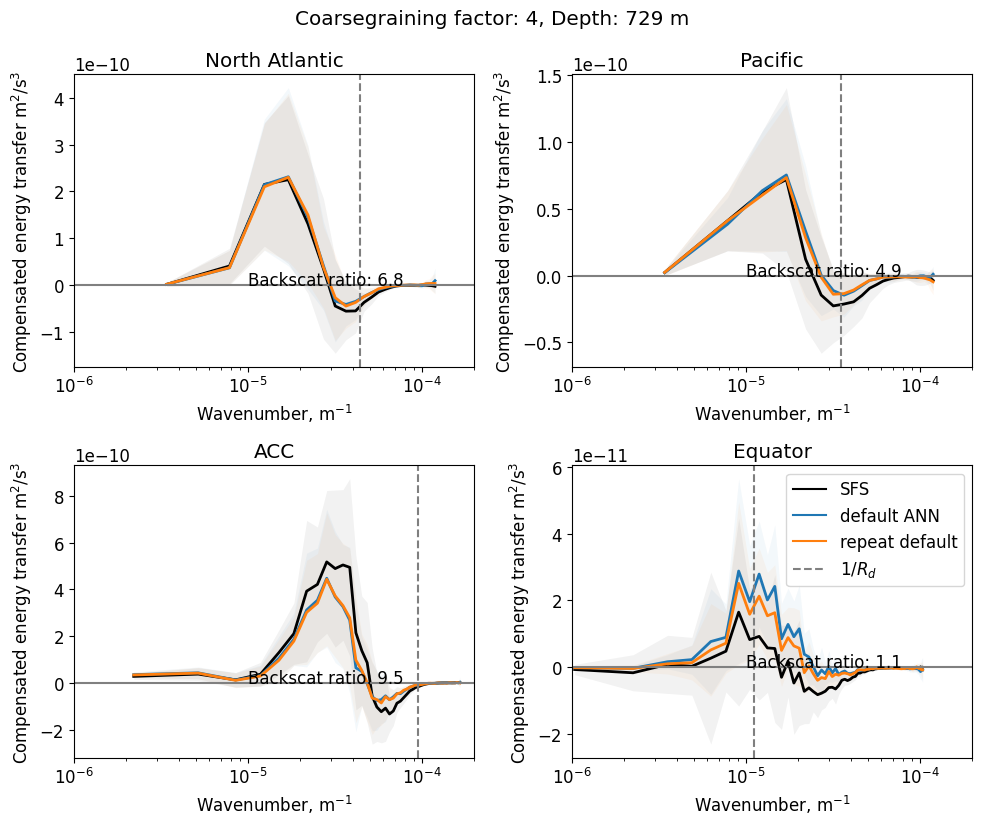

In [45]:
plot_transfer_4_regions(exps=[default, repeat],zl=5,factor=4,labels=['default ANN', 'repeat default'])

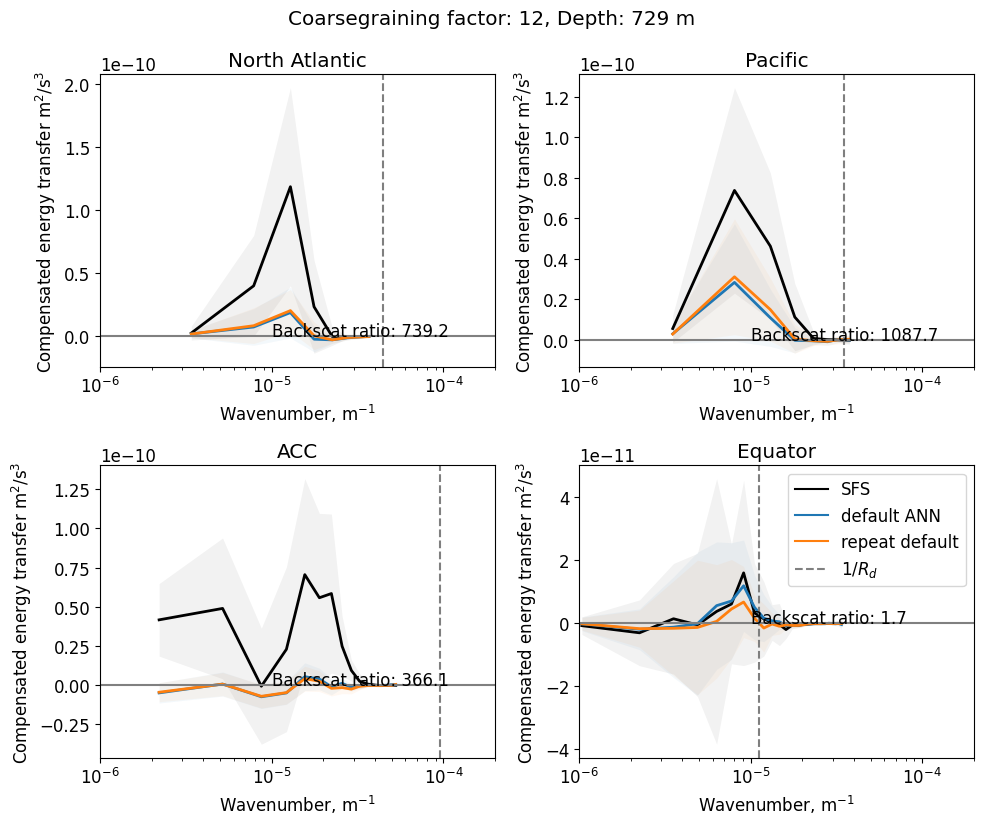

In [46]:
plot_transfer_4_regions(exps=[default, repeat],zl=5,factor=12,labels=['default ANN', 'repeat default'])

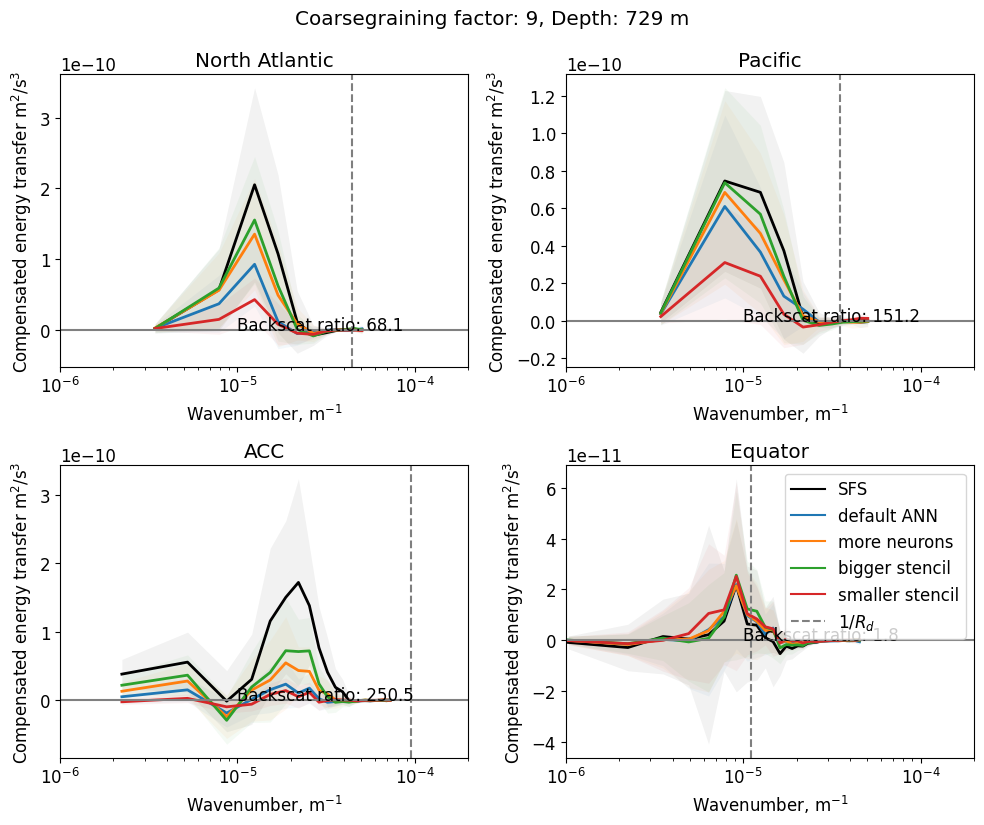

In [50]:
plot_transfer_4_regions(exps=[default, more_neurons, bigger_stencil, smaller_stencil],zl=5,factor=9,labels=['default ANN', 'more neurons', 'bigger stencil', 'smaller stencil'])